<a href="https://colab.research.google.com/github/charlie-1106/ML-Hub/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras import datasets

In [ ]:
(X_train, y_train),(X_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def preprocess(imgs):
    imgs=imgs.astype("float32")/255.0 #conversion of image to gray scale  so value will  be between 0 to 1

    imgs=np.pad(imgs,((0,0),(2,2),(2,2)),'constant',constant_values=0.0 )  #padding to have image size of 32x32
    imgs=np.expand_dims(imgs, -1) #expanding dimesions
    return imgs

X_train=preprocess(X_train)
X_test=preprocess(X_test)


Defining encoder structure

In [ ]:
from tensorflow.keras import layers,models
from tensorflow.keras import backend as K
encoder_input=layers.Input(
    shape=(32,32,1),         #encoder input layer
    name="encoder_input"
)
#2D CNN layers for feature extraction each capture high level feature incereasingly
x=layers.Conv2D(32,(3,3),strides=2,activation="relu",padding="same")(encoder_input)
x=layers.Conv2D(64,(3,3),strides=2,activation="relu",padding="same")(x)
x=layers.Conv2D(128,(3,3),strides=2,activation="relu",padding="same")(x)
shape_before_flattening=K.int_shape(x)[1:]
#flattening layer
x=layers.Flatten()(x)#

#Output layer
encoder_output=layers.Dense(2,name="encoder_output")(x)
#encoder model which takes image and convert it into 2D vector embeddings
encoder_model=models.Model(encoder_input,encoder_output,name="encoder_model")



Decoder

 using Conv2DTranspose layers which produces higher dimension images instead of halving as in Conv2d for example a 3 x 3 x 1 kernel is passed upon 3 x 3 x 1 image with strides =2 to produce an image of size 6 x 6 x 1 .Here they do the work of padding

In [ ]:
decoder_input=layers.Input(shape=(2,),name="decoder_input")
x=layers.Dense(np.prod(shape_before_flattening))(decoder_input) # Connecting input to Dense Layer
x=layers.Reshape(shape_before_flattening)(x) #Reshaping vector into Tensor to fed into Conv2DTranspose Layer
x=layers.Conv2DTranspose(128,(3,3),strides=2,activation="relu",padding="same")(x)
x=layers.Conv2DTranspose(64,(3,3),strides=2,activation="relu",padding="same")(x)
x=layers.Conv2DTranspose(32,(3,3),strides=2,activation="relu",padding="same")(x)

decoder_output=layers.Conv2D(1,(3,3),strides=1,activation="sigmoid",padding="same",name="decoder_output")(x)
decoder_model=models.Model(decoder_input, decoder_output) #Keras model that takes embedding in latent space and covert it into image

Auto encoder model

In [ ]:
from tensorflow.keras import Model
auto_encoder=Model(encoder_input, decoder_model(encoder_output))

Model Compilation with optimizer and loss

RMSE or MSE heavily penalizes the prediction which are bit far and tends to produce blurr images

In [ ]:
auto_encoder.compile(optimizer="adam",loss="binary_crossentropy")

Training

In [ ]:
auto_encoder.fit(
    X_train,
    X_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 227s 373ms/step - loss: 0.3628 - val_loss: 0.2600
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 261s 371ms/step - loss: 0.2568 - val_loss: 0.2549
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 261s 369ms/step - loss: 0.2525 - val_loss: 0.2529
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 231s 386ms/step - loss: 0.2513 - val_loss: 0.2513
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 262s 385ms/step - loss: 0.2497 - val_loss: 0.2508


Image Reconstruction

In [ ]:
example_images=X_test[:5000]
predictions=auto_encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step


Latent space Visulalization

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


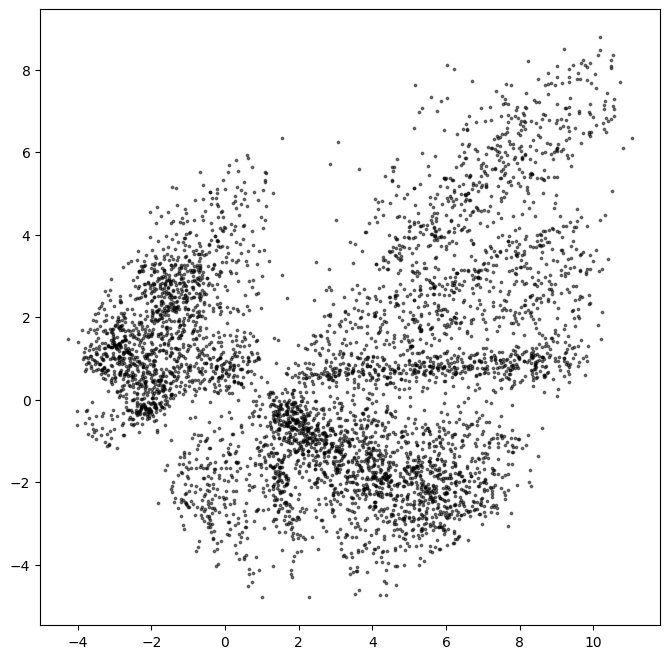

In [ ]:
import matplotlib.pyplot as plt

embeddings=encoder_model.predict(example_images)
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1],c="black",alpha=0.5, s=3)
plt.show()

Generating new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Original Images:


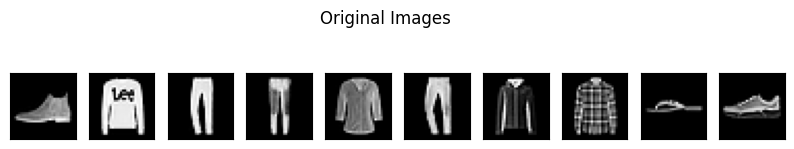

Reconstructed Images from Autoencoder:


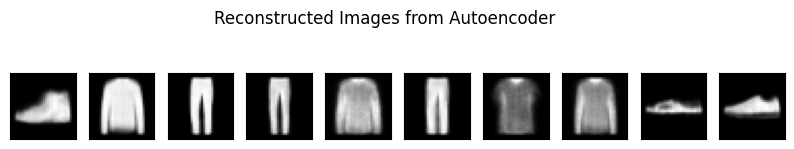

Generated Images from Latent Space:


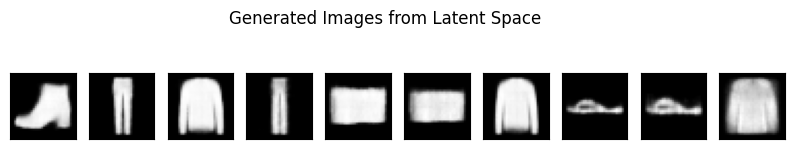

In [ ]:
mins, maxs=np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample=np.random.uniform(mins,maxs, size=(18,2))
reconstructions=decoder_model.predict(sample)

import matplotlib.pyplot as plt

def plot_images(images, title):
    n = len(images)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.show()

# Display some original, predicted, and reconstructed images
num_display = 10

print("Original Images:")
plot_images(example_images[:num_display], "Original Images")

print("Reconstructed Images from Autoencoder:")
plot_images(predictions[:num_display], "Reconstructed Images from Autoencoder")

print("Generated Images from Latent Space:")
plot_images(reconstructions[:num_display], "Generated Images from Latent Space")